In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as anim

import numpy as np

import sys
sys.path.insert(0, './code')

import ideal_gas

In [25]:
# length of cylinder
l = 0.1

# radius of cylinder
r = 0.05 

# thickness of wall
w = 0.006

# derived geometrical data
r2 = 2 * r          # diameter of cylinder
w2 = w / 2          # halved thickness of wall
l2 = l - w2
A = r**2 * np.pi    # cross-sectional area

In [26]:
def get_V_1(q):
    return A * (q - w2)
    
def get_V_2(q):
    return A * (l2 - q)

In [27]:
# density of aluminium
ρ_alu = 2700.0
ρ_copper = 8960.0

# mass of piston
m = ρ_copper * A * w

# thermal conductivity of aluminium
κ_alu = 237.0
κ_copper = 401.0

# thermal conduction coefficient
α = κ_copper * A / w


m_inv = 1 / m
m2 = 0.5 * m_inv

### initial conditions

determine $N_1$, $N_2$, $S_1$, $S_2$

In [28]:
# wanted conditions
V_1 = V_2 = get_V_1(l/2)
T_1 = 273.15 + 25.0
p_1 = 1.5 * 1e5
T_2 = 273.15 + 20.0
p_2 = 1.0 * 1e5

In [29]:
from scipy.optimize import fsolve

In [30]:
N_1 = fsolve(lambda N : ideal_gas.S_p(ideal_gas.U2(T_1, N), V_1, N) - p_1, x0=2e22)[0]
S_1 = ideal_gas.S(ideal_gas.U2(T_1, N_1), V_1, N_1)

In [31]:
ideal_gas.U_T(S_1, V_1, N_1) - 273.15

25.00000000000159

In [32]:
ideal_gas.U_p(S_1, V_1, N_1) * 1e-5

1.5000000000000082

In [33]:
N_2 = fsolve(lambda N : ideal_gas.S_p(ideal_gas.U2(T_2, N), V_2, N) - p_2, x0=2e22)[0]
S_2 = ideal_gas.S(ideal_gas.U2(T_2, N_2), V_2, N_2)

In [34]:
ideal_gas.U_T(S_2, V_2, N_2) - 273.15

20.00000000000415

In [35]:
ideal_gas.U_p(S_2, V_2, N_2) * 1e-5

1.0000000000000142

In [36]:
x_0 = l/2, 0, S_1, S_2

In [37]:
N_1, N_2

(1.345119603317771e+22, 9.120414116304357e+21)

In [40]:
S_1, S_2

(3.3828942208847232, 2.3394613409617655)

In [41]:
ideal_gas.U(S_1, V_1, N_1), ideal_gas.U(S_2, V_2, N_2)

(83.05585577928, 55.370570519520484)

In [42]:
def set_state(data, i, x):
    q, p, S_1, S_2 = x

    data[i, 0] = q
    
    data[i, 1] = p
    data[i, 2] = v = m_inv * p
    
    data[i, 3] = V_1 = get_V_1(q)
    data[i, 4] = p_1 = ideal_gas.U_p(S_1, V_1, N_1)
    
    data[i, 5] = S_1
    data[i, 6] = T_1 = ideal_gas.U_T(S_1, V_1, N_1)
    
    data[i, 7] = V_2 = get_V_2(q)
    data[i, 8] = p_2 = ideal_gas.U_p(S_2, V_2, N_2)

    data[i, 9] = S_2
    data[i, 10] = T_2 = ideal_gas.U_T(S_2, V_2, N_2)
    
    data[i, 11] = E_kin = m2 * p**2
    data[i, 12] = U_1 = ideal_gas.U(S_1, V_1, N_1)
    data[i, 13] = U_2 = ideal_gas.U(S_2, V_2, N_2)
    data[i, 14] = E = E_kin + U_1 + U_2
    data[i, 15] = S = S_1 + S_2

    
def get_state(data, i):
    return data[i, (0, 1, 5, 9)]

In [43]:
def F(x):
    q, p, S_1, S_2 = x
    
    V_1 = get_V_1(q)
    V_2 = get_V_2(q)
    
    p_1 = ideal_gas.U_p(S_1, V_1, N_1)
    p_2 = ideal_gas.U_p(S_2, V_2, N_2)
    
    T_1 = ideal_gas.U_T(S_1, V_1, N_1)
    T_2 = ideal_gas.U_T(S_2, V_2, N_2)
    
    return np.array((m_inv*p, A*(p_1-p_2), α*(T_2-T_1)/T_1, α*(T_1-T_2)/T_2))

In [67]:
t_f = 1.0
dt = 1e-4

steps = int(t_f // dt)
print(f'steps={steps}')
t = np.linspace(0, t_f, num=steps)
dt = t[1] - t[0]
data = np.empty((steps, 16), dtype=float)

set_state(data, 0, x_0)

x_old = get_state(data, 0)
for i in range(1, steps):
    x_new = x_old + dt * F(x_old)
    set_state(data, i, x_new)
    x_old = x_new


T_min = np.min(data[:, (6,10)])
T_max = np.max(data[:, (6,10)])

steps=9999


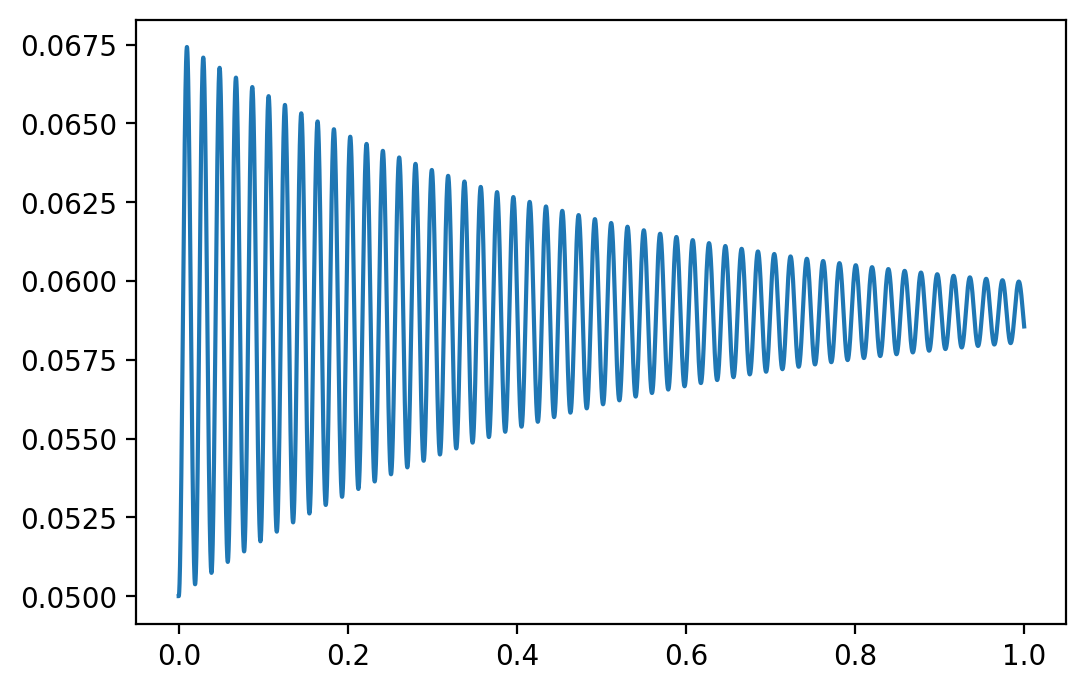

In [68]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, data[:, 0])

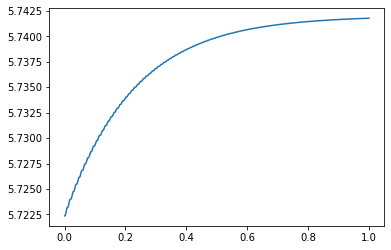

In [71]:
fig, ax = plt.subplots()
ax.plot(t, data[:, 15]); # total entropy

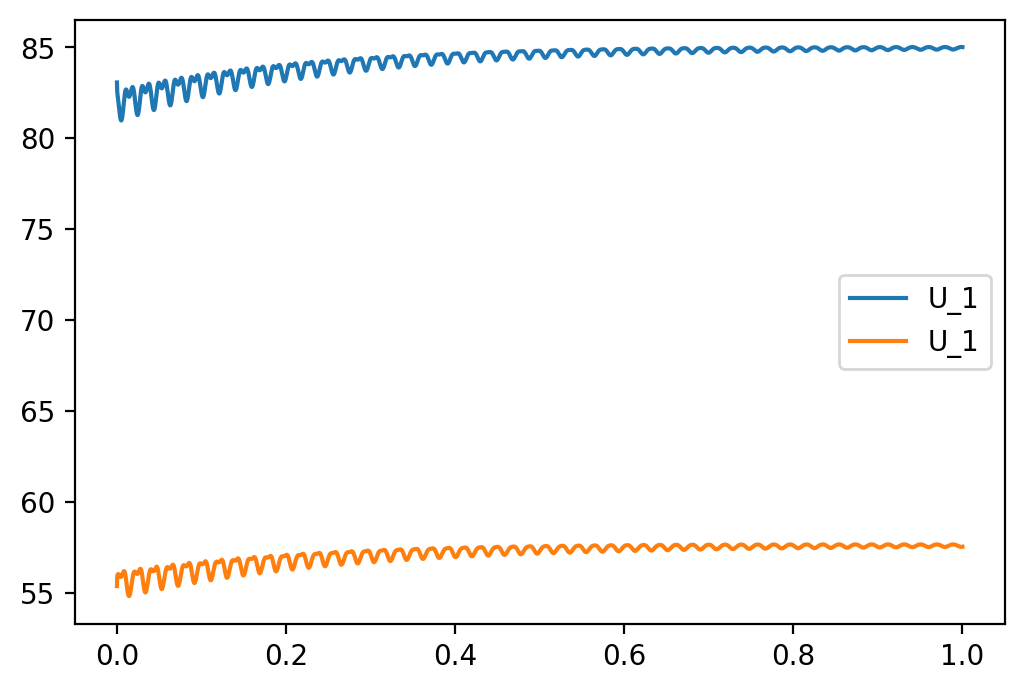

In [72]:
fig, ax = plt.subplots(dpi=200)
#ax.plot(t, data[:, 11], label='E_kin')
ax.plot(t, data[:, 12], label='U_1')
ax.plot(t, data[:, 13], label='U_1')
#ax.plot(t, data[:, 14], label='E')
ax.legend();

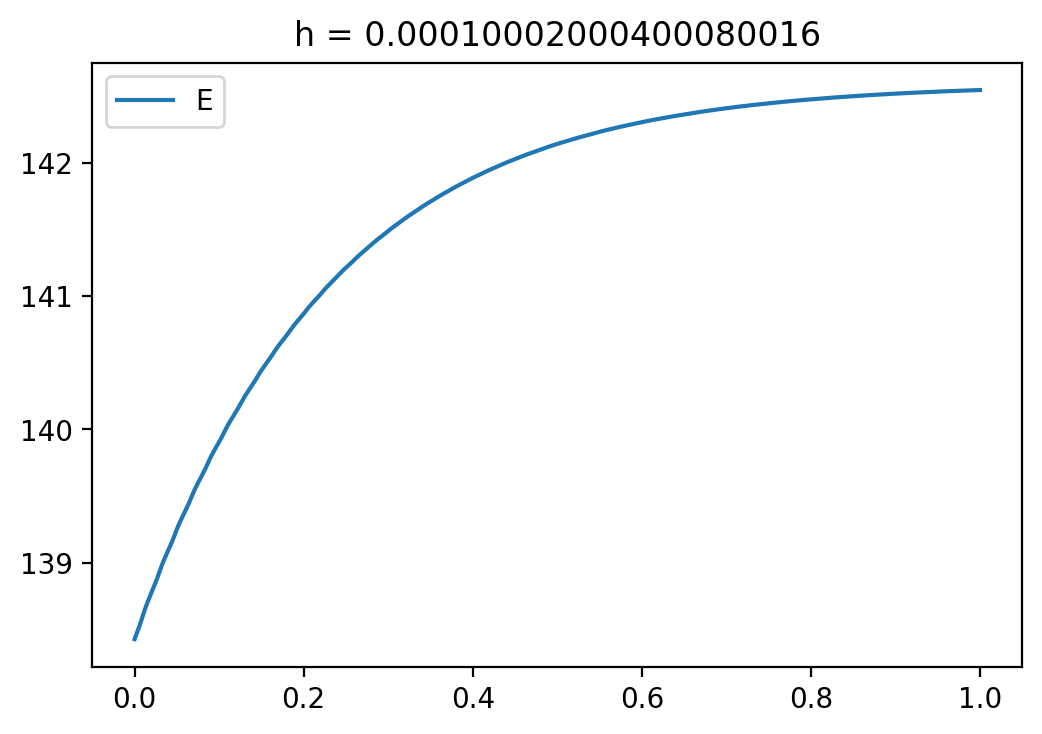

In [73]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, data[:, 14], label='E')
ax.set_title(f"h = {dt}")
ax.legend();

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, data[:, 14], label='E')
ax.set_title(f"h = {dt}")
ax.legend();

In [ ]:
plt.ioff()

cmap = matplotlib.cm.get_cmap('YlOrRd')

fig, ax = plt.subplots(dpi=100)
ax.set_xlim(left=0, right=l)
ax.set_ylim(bottom=-r, top=r)

q = l/2
vol1 = plt.Rectangle((0, -r), q-w2, r2, fc='b')
ax.add_patch(vol1)
pist = plt.Rectangle((q-w2, -r), w, r2, fc='#C84843')
ax.add_patch(pist)
vol2 = plt.Rectangle((q+w2, -r), l2-q, r2, fc='g')
ax.add_patch(vol2)

T_swing = T_max - T_min

def animate(datum):
    q = datum[0]
    T_1 = datum[6]
    T_2 = datum[10]
    
    l_1 = q - w2
    l_2 = l2 - q
    
    vol1.set_width(l_1)
    pist.set_x(l_1)
    vol2.set_x(l_1 + w)
    vol2.set_width(l_2)
    
    vol1.set_fc(cmap(0.8 * ((T_1-T_min) / T_swing)))
    vol2.set_fc(cmap(0.8 * ((T_2-T_min) / T_swing)))
    
    return (vol1, pist, vol2)

animation = anim.FuncAnimation(fig, animate, frames=data, interval=30, blit=True, repeat=False)
animation.save('piston.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.close(fig)